[View in Colaboratory](https://colab.research.google.com/github/nishkarshv/Udacity-ML/blob/master/LogisticReg.ipynb)

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Load a file by ID and create local file.
downloaded = drive.CreateFile({'id':'1os1T4eWQfmGNkCI8z4Fx3lJ39dWcsG4l'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('data\train.csv') # now you can use train.csv 
downloaded = drive.CreateFile({'id':'1fYwpjp6hsbvmvqagCCpa63Iqoil-Dgzq'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('data\test.csv') # now you can use train.csv 
downloaded = drive.CreateFile({'id':'1h32uyq4j5dU5xiHKT3V7VvF4EPNACuVD'}) # replace fileid with Id of file you want to access
downloaded.GetContentFile('data\sample_submission.csv') # now you can use train.csv 

In [0]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from __future__ import print_function
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import re

train = pd.read_csv('data\train.csv')
test = pd.read_csv('data\test.csv')
subm = pd.read_csv('data\sample_submission.csv')

In [3]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048919, 5000)

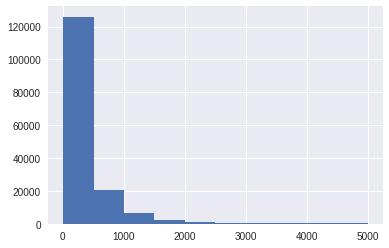

In [4]:
%matplotlib inline

lens.hist()

In [5]:
target = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[target].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


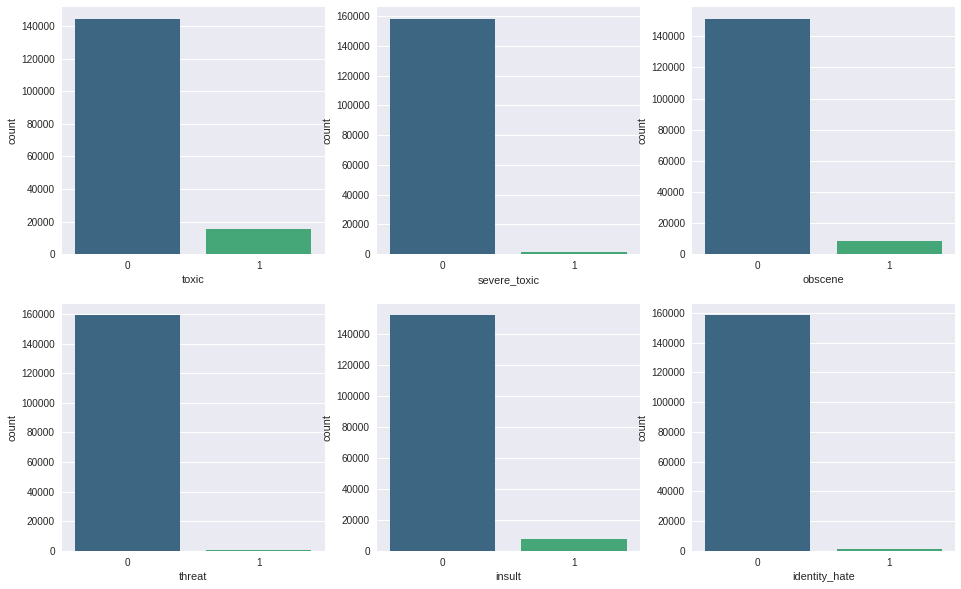

In [6]:
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'viridis',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'viridis',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'viridis',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'viridis', ax = ax6)

In [7]:
test.fillna('missing',inplace=True)

#[x for x in target train_df[x].sum()/len(train_df)]#[x for 

base_accuracy = []
print("Base Accuracy for Each Label")
for i in target:
    base_acc = ((train[i] == 0).sum()/len(train[i]))*100
    print(i+':' ,format(base_acc))
    base_accuracy.append(base_acc)
print(50*'_')
print(base_accuracy)

Base Accuracy for Each Label
toxic: 90.41555169799024
severe_toxic: 99.00044494300343
obscene: 94.7051782592075
threat: 99.70044682304429
insult: 95.06363938309592
identity_hate: 99.11951419744189
__________________________________________________
[90.41555169799024, 99.00044494300343, 94.7051782592075, 99.70044682304429, 95.06363938309592, 99.11951419744189]


In [0]:
#TEXT PREPROCESSING
def clean_text(text):
  text = re.sub(r"what's", "what is", text)
  text = re.sub(r"\'s", " ", text)
  text = re.sub(r"\'ve"," have " , text)
  text = re.sub(r"can't", "cannot ", text)
  text = re.sub(r"n't", " not ", text)
  text = re.sub(r"i'm","i am", text)
  text = re.sub(r"\'re"," are ", text)
  text = re.sub(r"\'d"," would ", text)
  text = re.sub(r"\'ll'"," will ", text)
  text = re.sub(r"\'scuse", " excuse ", text)
  text = re.sub('\W', ' ', text)
  text = re.sub('\s+', ' ', text)
  text = text.strip(' ')
  return text

# clean the comment_text in train_df
cleaned_train_comment = []
for i in range(0,len(train)):
 # print(train['comment_text'][i])
  cleaned_comment = clean_text(train['comment_text'][i])
  cleaned_train_comment.append(cleaned_comment)
train['comment_text'] = pd.Series(cleaned_train_comment).astype(str)

In [0]:
#Test set
cleaned_test_comment = []
for i in range(0,len(test)):
  cleaned_comment = clean_text(test['comment_text'][i])
  cleaned_test_comment.append(cleaned_comment)
test['comment_text'] = pd.Series(cleaned_test_comment).astype(str)

In [10]:
X=train.comment_text
text_X=test.comment_text

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=40000,stop_words='english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=40000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [11]:
X=train.comment_text
text_X=test.comment_text
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<159571x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 3820459 stored elements in Compressed Sparse Row format>

In [12]:
X=train.comment_text
text_X=test.comment_text

test_X_dtm = vect.transform(text_X)
# examine the document-term matrix from X_test
test_X_dtm

<153164x40000 sparse matrix of type '<class 'numpy.float64'>'
	with 3175050 stored elements in Compressed Sparse Row format>

In [13]:
#import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

# create submission file
submission_binary = pd.read_csv("data\sample_submission.csv")

change_acc_bin = []
for i,label in enumerate(target):
    print('... Processing {}'.format(label))
    print(label+" is: ",base_accuracy[i])
    y = train[label]
    # train the model using X_dtm & y
    logreg.fit(X_dtm, y)
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is         {}'.format(accuracy_score(y, y_pred_X)*100))
    print("Increase from Base accuracy is {}".format(accuracy_score(y, y_pred_X)*100 - base_accuracy[i]))
    change_acc_bin.append(accuracy_score(y, y_pred_X)*100 - base_accuracy[i])
    print("")
    print(50*'_')
    # compute the predicted probabilities for X_test_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]
    submission_binary[label] = test_y_prob

... Processing toxic
toxic is:  90.41555169799024
Training accuracy is         97.90500780216956
Increase from Base accuracy is 7.489456104179325

__________________________________________________
... Processing severe_toxic
severe_toxic is:  99.00044494300343
Training accuracy is         99.41092053067287
Increase from Base accuracy is 0.41047558766943837

__________________________________________________
... Processing obscene
obscene is:  94.7051782592075
Training accuracy is         98.98979137813262
Increase from Base accuracy is 4.284613118925122

__________________________________________________
... Processing threat
threat is:  99.70044682304429
Training accuracy is         99.87341058212333
Increase from Base accuracy is 0.17296375907903894

__________________________________________________
... Processing insult
insult is:  95.06363938309592
Training accuracy is         98.4633799374573
Increase from Base accuracy is 3.3997405543613866

____________________________________

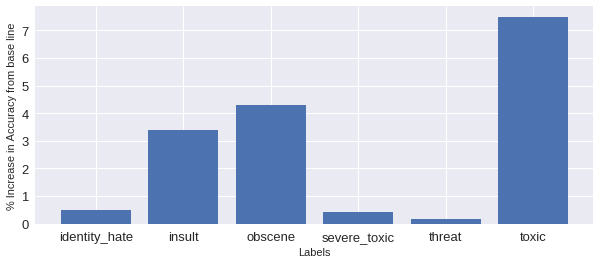

In [14]:
plt.bar(target,change_acc_bin)
plt.ylabel("% Increase in Accuracy from base line")
plt.xlabel("Labels")
plt.gcf().set_size_inches(10,4)
plt.tick_params(labelsize=13)
plt.show()